In [1]:
import pandas as pd
import pickle
import networkx as nx

In [2]:
MLN = pickle.load(open('../Multilayer Network/MLN.pickle', 'rb'))
user_layer = pickle.load(open('../Multilayer Network/user_layer.pickle', 'rb'))
content_layer = pickle.load(open('../Multilayer Network/content_layer.pickle', 'rb'))

In [9]:
import multiprocessing as mp

def compute_centralities(network, centrality_func):
    centralities = nx.degree_centrality(network) if centrality_func == 'degree' else \
                  nx.betweenness_centrality(network) if centrality_func == 'betweenness' else \
                  nx.eigenvector_centrality(network) if centrality_func == 'eigenvector' else {}
    return centralities

def parallel_compute_centralities(network, centrality_funcs):
    pool = mp.Pool(processes=mp.cpu_count())
    results = [pool.apply_async(compute_centralities, args=(network, centrality_func)) for centrality_func in centrality_funcs]
    centralities = [r.get() for r in results]
    return centralities

centrality_funcs = ['degree', 'betweenness', 'eigenvector']
centralities = parallel_compute_centralities(user_layer, centrality_funcs)
degree_centralities, betweenness_centralities, eigenvector_centralities = centralities

In [10]:
def normalize_values(dictionary):
    min_value = min(dictionary.values())
    max_value = max(dictionary.values())
    for user in dictionary.keys():
        dictionary[user] = (dictionary[user] - min_value) / (max_value - min_value)
    return dictionary

degree_centralities = normalize_values(degree_centralities)
betweenness_centralities = normalize_values(betweenness_centralities)
eigenvector_centralities = normalize_values(eigenvector_centralities)

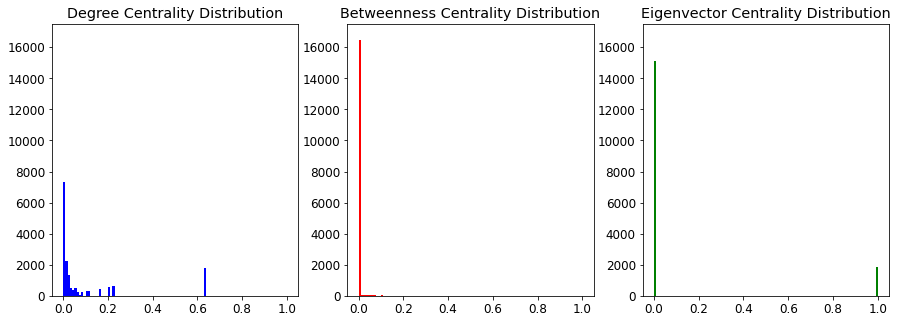

In [11]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

# Extract the values from the dictionaries
degree_values = list(degree_centralities.values())
betweenness_values = list(betweenness_centralities.values())
eigenvector_values = list(eigenvector_centralities.values())

# Plot the distributions in 3 different plots in a same figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hist(degree_values, bins=100, color='blue')
ax1.set_ylim(0,17500)
ax1.set_title('Degree Centrality Distribution')
ax2.hist(betweenness_values, bins=100, color='red')
ax2.set_ylim(0,17500)
ax2.set_title('Betweenness Centrality Distribution')
ax3.hist(eigenvector_values, bins=100, color='green')
ax3.set_ylim(0,17500)
ax3.set_title('Eigenvector Centrality Distribution')
plt.savefig('centralities.pdf')
plt.show()

In [12]:
import numpy as np
import pickle

def topsis(degree_centralities, betweenness_centralities, eigenvector_centralities, weights, impact):
    n = len(degree_centralities)
    decision_matrix = np.zeros((n, 3))
    decision_matrix[:, 0] = list(degree_centralities.values())
    decision_matrix[:, 1] = list(betweenness_centralities.values())
    decision_matrix[:, 2] = list(eigenvector_centralities.values())
    weighted_matrix = decision_matrix * weights
    normalized_matrix = weighted_matrix / np.linalg.norm(weighted_matrix, axis=0)
    ideal_positive = np.max(normalized_matrix, axis=0) * impact
    ideal_negative = np.min(normalized_matrix, axis=0) * impact
    distances_positive = np.linalg.norm(ideal_positive - normalized_matrix, axis=1)
    distances_negative = np.linalg.norm(normalized_matrix - ideal_negative, axis=1)
    relative_closeness = distances_negative / (distances_negative + distances_positive)
    key_users = [user for user, value in zip(degree_centralities.keys(), relative_closeness) if value >= np.mean(relative_closeness)]
    return key_users

weights = np.array([0.33, 0.33, 0.34]) # assign equal weights to each criterion
impact = np.array([1, 1, 1]) # assign positive impact to each criterion
key_users = topsis(degree_centralities, betweenness_centralities, eigenvector_centralities, weights, impact)
pickle.dump(key_users, open('key_users.pickle', 'wb'))
print(len(key_users))

3834


In [44]:
keyusers_net = user_layer.subgraph(key_users)
len(keyusers_net.edges)

2254509

In [45]:
print(nx.density(keyusers_net))

0.3068252107654187


In [3]:
import multiprocessing as mp
key_users = pickle.load(open('key_users.pickle', 'rb'))

In [4]:
user_content_layer = nx.Graph()
for u in key_users:
    user_content_layer.add_node(u)
multi_layer_edges = [(u,v,data) for u,v,data in MLN.edges(data=True) if data['layer']=='multi_u_c']
multi_layer_edges = [edge for edge in multi_layer_edges if edge[0] in key_users or edge[1] in key_users]
content_edges = [(c1,c2,data) for c1,c2,data in MLN.edges(data=True) if data['layer']=='content']
del MLN
del user_layer
del content_layer

In [5]:
content_to_user_map = {}
for edge in multi_layer_edges:
    if edge[1] not in content_to_user_map:
        content_to_user_map[edge[1]] = []
    content_to_user_map[edge[1]].append(edge[0])
content_to_user_map_filtered = {}
for c in content_to_user_map:
    if len(content_to_user_map[c]) > 1:
        content_to_user_map_filtered[c] = content_to_user_map[c]

In [6]:
content_edges = [(c1,c2,data) for c1,c2,data in content_edges if c1 in content_to_user_map_filtered.keys() or c2 in content_to_user_map_filtered.keys()]
result = {}
for content_node, user_nodes in content_to_user_map_filtered.items():
    for c1,c2,data in content_edges:
        topics = []
        if (c1 == content_node or c2 == content_node) and data['layer'] == 'content':
            topics.extend(data['label'])
        topics = list(set(topics))
        for i, u1 in enumerate(user_nodes):
            for u2 in user_nodes[i+1:]:
                try:
                    result[(u1,u2)].extend(topics)
                    result[(u1,u2)] = list(set(result[(u1,u2)]))
                except:
                    result[(u1,u2)] = topics

In [8]:
len(result)

691

In [9]:
for res in result.keys():
    user_content_layer.add_edge(res[0], res[1], label=result[res])

In [11]:
print(len(user_content_layer.nodes))
print(len(user_content_layer.edges))
print(nx.density(user_content_layer))

3834
691
9.404097328460623e-05


In [12]:
nx.number_of_isolates(user_content_layer)

3254

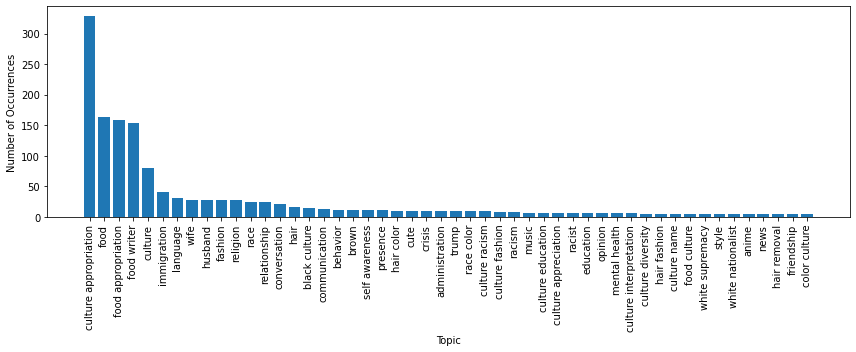

In [24]:
import matplotlib.pyplot as plt
from collections import defaultdict

plt.figure(figsize=(12,5))
all_topics = []
for topic_list in result.values():
    all_topics.extend(topic_list)
topic_counts = dict()
for topic in all_topics:
    if topic in topic_counts:
        topic_counts[topic] += 1
    else:
        topic_counts[topic] = 1

# Order topic counts by number of occurrences
sorted_topic_counts = dict(sorted(topic_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the top 50 topics
labels = list(sorted_topic_counts.keys())[:50]
values = list(sorted_topic_counts.values())[:50]
plt.bar(labels, values)
plt.xlabel('Topic')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('topics_key.pdf')
plt.show()

In [25]:
commentkey_user

{'culture appropriation': 328,
 'food': 164,
 'food appropriation': 158,
 'food writer': 153,
 'culture': 80,
 'immigration': 41,
 'language': 31,
 'wife': 28,
 'husband': 28,
 'fashion': 27,
 'religion': 27,
 'race': 25,
 'relationship': 25,
 'conversation': 21,
 'hair': 16,
 'black culture': 15,
 'communication': 13,
 'behavior': 11,
 'brown': 11,
 'self awareness': 11,
 'presence': 11,
 'hair color': 10,
 'cute': 10,
 'crisis': 10,
 'administration': 10,
 'trump': 10,
 'race color': 10,
 'culture racism': 9,
 'culture fashion': 8,
 'racism': 8,
 'music': 7,
 'culture education': 7,
 'culture appreciation': 6,
 'racist': 6,
 'education': 6,
 'opinion': 6,
 'mental health': 6,
 'culture interpretation': 6,
 'culture diversity': 5,
 'hair fashion': 5,
 'culture name': 5,
 'food culture': 5,
 'white supremacy': 4,
 'style': 4,
 'white nationalist': 4,
 'anime': 4,
 'news': 4,
 'hair removal': 4,
 'friendship': 4,
 'color culture': 4,
 'culture appropriateness': 4,
 'cool': 3,
 'liberati